Scale factor: 4x


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████| 141/141 [09:20<00:00,  3.98s/it]


Epoch 1 | Train Loss: 0.0566 | PSNR: 26.47 | SSIM: 0.7220 | Joint: 55.35


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████| 141/141 [09:14<00:00,  3.93s/it]


Epoch 2 | Train Loss: 0.0425 | PSNR: 26.35 | SSIM: 0.7273 | Joint: 55.45


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████| 141/141 [09:12<00:00,  3.92s/it]


Epoch 3 | Train Loss: 0.0418 | PSNR: 26.76 | SSIM: 0.7485 | Joint: 56.71


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████| 141/141 [09:20<00:00,  3.97s/it]


Epoch 4 | Train Loss: 0.0411 | PSNR: 26.79 | SSIM: 0.7526 | Joint: 56.90


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████| 141/141 [08:22<00:00,  3.57s/it]


Epoch 5 | Train Loss: 0.0410 | PSNR: 26.84 | SSIM: 0.7593 | Joint: 57.21


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████| 141/141 [08:27<00:00,  3.60s/it]


Epoch 6 | Train Loss: 0.0410 | PSNR: 26.84 | SSIM: 0.7610 | Joint: 57.28


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████| 141/141 [08:33<00:00,  3.64s/it]


Epoch 7 | Train Loss: 0.0399 | PSNR: 26.85 | SSIM: 0.7705 | Joint: 57.67


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████| 141/141 [08:18<00:00,  3.53s/it]


Epoch 8 | Train Loss: 0.0397 | PSNR: 26.88 | SSIM: 0.7686 | Joint: 57.63


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████| 141/141 [08:26<00:00,  3.60s/it]


Epoch 9 | Train Loss: 0.0392 | PSNR: 26.92 | SSIM: 0.7651 | Joint: 57.53


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████| 141/141 [08:29<00:00,  3.62s/it]


Epoch 10 | Train Loss: 0.0397 | PSNR: 26.93 | SSIM: 0.7588 | Joint: 57.28


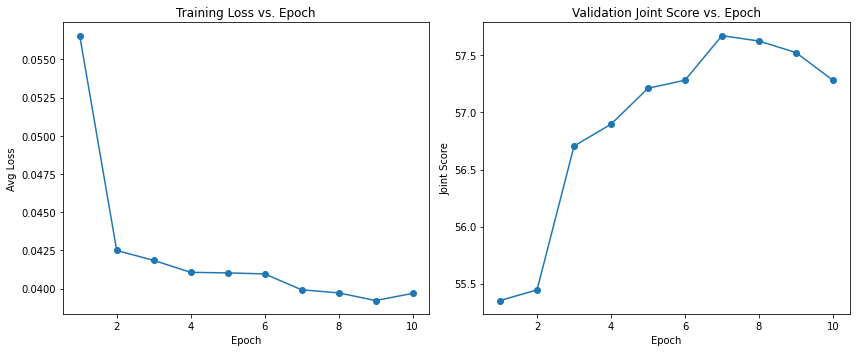

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [01:32<00:00,  5.42it/s]


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import base64
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Verify dataset scale factor
lr_sample = cv2.imread("train-kaggle/train-kaggle/lr/00001.png")
hr_sample = cv2.imread("train-kaggle/train-kaggle/hr/00001.png")
SCALE_FACTOR = int(hr_sample.shape[0] / lr_sample.shape[0])
print(f"Scale factor: {SCALE_FACTOR}x")

# EDSR Architecture with dynamic scaling
class EDSR(nn.Module):
    def __init__(self, scale_factor=SCALE_FACTOR, num_blocks=32, feature_dim=256):
        super(EDSR, self).__init__()
        self.scale_factor = scale_factor
        self.head = nn.Conv2d(3, feature_dim, 3, padding=1)  # Initial convolution layer
        self.body = nn.Sequential(*[ResBlock(feature_dim) for _ in range(num_blocks)])  # Residual blocks
        
        upscale = []
        num_upscales = int(np.log2(scale_factor))  # Determine number of upscaling stages
        for _ in range(num_upscales):
            upscale.extend([
                nn.Conv2d(feature_dim, feature_dim * 4, 3, padding=1),  # Increase channel dimension
                nn.PixelShuffle(2)  # Rearrange channels to upscale spatial dimensions
            ])
        upscale.append(nn.Conv2d(feature_dim, 3, 3, padding=1))  # Final conv to output RGB image
        self.tail = nn.Sequential(*upscale)

    def forward(self, x):
        x = self.head(x)            # Pass input through initial conv layer
        residual = x                # Save for residual connection
        x = self.body(x)            # Process through residual blocks
        x += residual               # Add residual connection
        x = self.tail(x)            # Upscale the image
        return x

# Residual Block used in EDSR
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)  # First conv layer
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)  # Second conv layer
        self.relu = nn.ReLU()                                    # Activation function
        
    def forward(self, x):
        residual = x                    # Save input for residual connection
        x = self.relu(self.conv1(x))    # Apply convolution and activation
        x = self.conv2(x)               # Apply second convolution
        x += residual                   # Add skip connection
        return x

# Dataset Class
class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, scale=SCALE_FACTOR, patch_size=64, train=True):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.scale = scale
        self.patch_size = patch_size
        self.train = train
        self.filenames = [f for f in os.listdir(lr_dir) if f.endswith('.png')]
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        lr_path = os.path.join(self.lr_dir, self.filenames[idx])
        hr_path = os.path.join(self.hr_dir, self.filenames[idx])
        
        lr = cv2.imread(lr_path)
        hr = cv2.imread(hr_path)
        lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
        hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
        
        assert hr.shape[0] == lr.shape[0] * self.scale, "HR/LR scale mismatch"
        assert hr.shape[1] == lr.shape[1] * self.scale, "HR/LR scale mismatch"
        
        if self.train:
            lr_h, lr_w = lr.shape[:2]
            lr_p = self.patch_size
            hr_p = self.patch_size * self.scale
            lr_x = np.random.randint(0, lr_w - lr_p)
            lr_y = np.random.randint(0, lr_h - lr_p)
            hr_x = lr_x * self.scale
            hr_y = lr_y * self.scale
            lr = lr[lr_y:lr_y+lr_p, lr_x:lr_x+lr_p]
            hr = hr[hr_y:hr_y+hr_p, hr_x:hr_x+hr_p]
        
        lr_tensor = transforms.functional.to_tensor(lr)
        hr_tensor = transforms.functional.to_tensor(hr)
        return lr_tensor, hr_tensor

# Training configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
EPOCHS = 10
LR = 5e-5

train_set = SRDataset('train-kaggle/train-kaggle/lr', 'train-kaggle/train-kaggle/hr', train=True)
val_set = SRDataset('train-kaggle/train-kaggle/lr', 'train-kaggle/train-kaggle/hr', train=False)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

# Fixed validation indices for consistent evaluation each epoch
num_val_samples = 100
val_indices = np.random.choice(len(val_set), num_val_samples, replace=False)
val_subset = Subset(val_set, val_indices)
subset_loader = DataLoader(val_subset, batch_size=1, shuffle=False)

model = EDSR(scale_factor=SCALE_FACTOR).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

train_losses = []
val_joint_scores = []

# Training loop
best_metric = 0
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for lr, hr in tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}'):
        lr, hr = lr.to(device), hr.to(device)
        optimizer.zero_grad()
        sr = model(lr)
        loss = criterion(sr, hr)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    model.eval()
    psnr_val, ssim_val = 0, 0
    with torch.no_grad():
        for lr, hr in subset_loader:
            lr, hr = lr.to(device), hr.to(device)
            sr = model(lr)
            sr_np = sr.squeeze().cpu().numpy().transpose(1,2,0) * 255
            hr_np = hr.squeeze().cpu().numpy().transpose(1,2,0) * 255
            psnr_val += psnr(hr_np, sr_np, data_range=255)
            ssim_val += ssim(hr_np, sr_np, channel_axis=2, data_range=255, multichannel=True)
    
    avg_psnr = psnr_val / num_val_samples
    avg_ssim = ssim_val / num_val_samples
    joint_metric = 40 * avg_ssim + avg_psnr
    val_joint_scores.append(joint_metric)
    
    print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f} | PSNR: {avg_psnr:.2f} | SSIM: {avg_ssim:.4f} | Joint: {joint_metric:.2f}")
        
    if joint_metric > best_metric:
        best_metric = joint_metric
        torch.save(model.state_dict(), 'bestmodel.pth')
    
    scheduler.step(avg_loss)

# Plot training loss vs epoch and validation joint score vs epoch
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, EPOCHS+1), train_losses, marker='o')
plt.title("Training Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Avg Loss")

plt.subplot(1,2,2)
plt.plot(range(1, EPOCHS+1), val_joint_scores, marker='o')
plt.title("Validation Joint Score vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Joint Score")

plt.tight_layout()
plt.show()

# Inference with automatic scaling
def predict_and_save(test_dir='lr/lr', output_dir='Sub'):
    os.makedirs(output_dir, exist_ok=True)
    model.load_state_dict(torch.load('bestmodel.pth'))
    model.eval()
    for filename in tqdm(os.listdir(test_dir)):
        lr_path = os.path.join(test_dir, filename)
        lr = cv2.imread(lr_path)
        lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
        h, w = lr.shape[:2]
        pad_h = (SCALE_FACTOR - h % SCALE_FACTOR) % SCALE_FACTOR
        pad_w = (SCALE_FACTOR - w % SCALE_FACTOR) % SCALE_FACTOR
        lr_padded = cv2.copyMakeBorder(lr, 0, pad_h, 0, pad_w, cv2.BORDER_REFLECT)
        lr_tensor = transforms.functional.to_tensor(lr_padded).unsqueeze(0).to(device)
        with torch.no_grad():
            sr_tensor = model(lr_tensor)
        sr_np = sr_tensor.squeeze().cpu().numpy().transpose(1,2,0)
        sr_np = (sr_np * 255).clip(0, 255).astype(np.uint8)
        sr_np = sr_np[:h*SCALE_FACTOR, :w*SCALE_FACTOR]
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, cv2.cvtColor(sr_np, cv2.COLOR_RGB2BGR))

predict_and_save()

# Generate submission CSV
def create_submission(output_dir='Sub', csv_path='Submission.csv'):
    encoded = []
    for fname in tqdm(os.listdir(output_dir)):
        img_path = os.path.join(output_dir, fname)
        image = cv2.imread(img_path)
        _, buffer = cv2.imencode('.png', image)
        b64 = base64.b64encode(buffer).decode('utf-8')
        encoded.append({'id': fname, 'Encoded_Image': b64})
    pd.DataFrame(encoded).to_csv(csv_path, index=False)

create_submission()
